## Trabajo Semanal 5 - BETTIG
### Estimación espectral. Método de Welch y de Blackman Tukey 

Para una señal:
$$ x(k) = a_1.sen({\ohm}_1.k) + n(k)$$
Siendo:
$$ {\ohm}_1 = {\ohm}_0 + f_r\frac{2\pi}{N}$$
$$ {\ohm}_0 = \frac{\pi}{2}$$
Y las variables aleatorias definidas por:
$$ f_r \sim U(-\frac{1}{2}, \frac{1}{2}) $$
$$ n \sim N(0, \sigma^2)$$ 
Se evaluará el siguiente estimador $ \ohm_1 $ (estimador de frecuencia) utilizando el método de Blackman-Tukey y el de Welch:
$$ \hat{{\ohm}_1} = arg_f\{Max\{\hat{P}\}\}$$
Siguiendo las siguientes consignas:
 - Considere 200 realizaciones de 1000 muestras para cada experimento.
 -  Parametrice para SNR's de 3 y 10 db.

### Desarrollo del Trabajo

Primero que nada, voy a incluir las bibliotecas necesarias para el desarrollo de la tarea

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
import spectrum as sp

np.seterr(divide = 'ignore');

def sin_gen(vmax = 1, dc = 0, ff = 1, ph = 0, nn = 1000, fs = 1000):
    # Lo primero que hay que hacer es crear un vector temporal que determinará
    # el inicio y el fin de la señal
    ts = 1/fs   # Tiempos de muestreo, intervalo de tiempo en el que se  
                # tomarán las muestras
    tf = nn * ts # Tiempo final de la señal
    tt = np.arange(0, tf, ts) # Creo el vector temporal
    ##
    # Ahora tengo que generar mi señal senoidal, para eso voy a aprovechar
    # la función np.sin de la biblioteca numpy. Para ello, debemo evaluar
    # dicha función en cada uno de los puntos del vector temporal creado
    # previamente
    xx = vmax * np.sin(2 * np.pi * ff * tt + ph) + dc
    ##
    # Devuelvo el vector temporal y el valor de la señal en cada uno de esos
    # puntos
    return tt, xx

# Sabemos que la varianza de una función aleatoria con distribución
# uniforme puede ser calculada como Var(X) = q²/12
def rnd_nmbrs_gen(var, N):
    q = math.sqrt(var*12);
    rnd_numbers = q * np.random.random(N) - (q/2);
    return rnd_numbers;

# El objetivo de la función es obtener una señal aleatoria a partir de una
# relación señal a ruido definida por parámetro, considerando como señal
# una senoidal de amplitud normalizada ( sqrt(2) ) 
def noise_gen(snr, N):
    # Lo primero que tenemos que hacer es obtener la varianza de la señal
    # aleatoria, tengamos en cuenta que esto está normalizado, por lo que
    # luego habría que desnormalizar
    var = np.power(10.0,snr/(-10.0));
    return rnd_nmbrs_gen(var, N);

Voy a definir algunas variables de entorno que me permitirán parametrizar la experiencia. En primer instancia, el número de realizaciones (n_run en el código) será de 200 y la SNR será de 3dB

In [2]:
# Con esta frecuencia representaré la señal analógica 
# (voy a trabajar normalizado)

f_cont  = 1000      # Frecuencia continua
N       = f_cont    # Cantidad de muestras de señal continua

# Establezco  la relación señal a ruido que tendrá y la amplitud 
# de la misma (Potencia unitaria)

snr     = 3                 # Relación señal a ruido
A_sin   = math.sqrt(2);     # Amplitud de Senoidal para potencia normalizada

# Por otro lado, la experiencia tendrá "n_run" realizaciones, por lo que me voy
# a crear una matriz vacía que contemple todas las muestras

n_run = 200;
y_sin = np.empty((n_run, N), float);
y_noise = np.empty((n_run, N), float);
noisy_sin = np.empty((n_run, N), float);

Voy a definir las **n_run** señales senoidales con sus correspondientes ruidos aleatorios para podes realizar la tarea. Hay que tener en cuenta que el jitter que se agrega a la frecuencia de la señal también dependerá de la realización, no es el mismo para todas:

In [3]:
# Me creo un eje temporal con el que voy a plotear mis señales
# t_axis = np.arange(0, N*1/f_cont, 1/f_cont);

for i in range(n_run):
    # Primero voy a generar la secuencia de números aleatorios que va representar
    # mi variación en frecuencia
    q = 0.5;
    ohmega_0 = f_cont/4;
    fr = np.random.uniform(-q,q);
    ohmega = ohmega_0 + fr
    
    # Ahora voy a generar mi senoidal con la frecuencia obtenida anteriormente
    t, y_sin[i] = sin_gen(A_sin, 0, ohmega, 0, N, f_cont);
    
    # Luego, voy a calcular el ruido que debo adicionar a la senoidal, con
    # la SNR deseada:
    y_noise[i] = (A_sin/(math.sqrt(2))) * noise_gen(snr, N);
    
    # La señal final será la suma de ambas:
    noisy_sin[i] = y_sin[i] + y_noise[i];

A diferencia de la práctica anterior, no voy a realizar un ventaneo de forma directa (señal x ventana), sino que lo realizaré indirectamente a través de la funciones Welch (para aplicar el método de Welch) y CORRELOGRAMPSD (Para el de Blackman-Tukey). En ambos casos les explicitaré la ventana. No es ningún requerimiento el tipo de ventana usar, por lo que usaré **Bartlett** (No existe ninguna razón especial, simplemente elegí una que previamente no haya usado). 
<br>
Por otro lado, para el caso de Blackman-Tukey, debo especificar la cantidad de muestras efectivas al momento de hacer la autocorrelación. Recordemos que la idea de esto era descartar todas aquellas muestras cuya estimación sea mala. De esta forma se disminuye el sesgo. Dicho parámetro será **M**, y en mi caso lo fijaré en 100 muestras. Luego, debo hacer un padding para volver a la cantidad original de muestras, ya que necesito mantener coherencia en el eje horizontal para poder realizar una comparación.

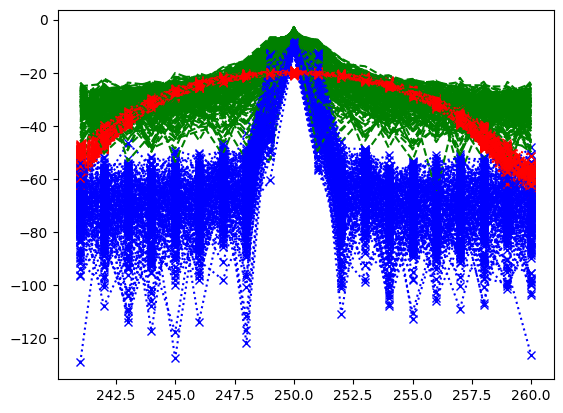

In [5]:
# Este margen lo voy a usar para plotear solamente el area de interes
margin  = 10;
M       = 100;
 
# Armo unos vectores de frecuencia para poder plotear los resultados
frec_axis_cont      = np.arange(0, f_cont, f_cont/N);
frec_axis_cont_filt = (frec_axis_cont > (f_cont/4 - margin)) & (frec_axis_cont <= (f_cont/4 + margin));

fft_noisy_sin       = np.empty((n_run, N), float);

fft_welch_sin       = np.empty((n_run, N), float);
f_welch_sin         = np.empty((n_run, N), int);

frec_axis_blackman  = np.arange(0, N, 1);
fft_bt_sin          = np.empty((n_run, N), float)

fig1, (ax1)         = plt.subplots(1);

# Ahora voy a hacer una fft para conocer el espectro de cada una de esas 
# señales que obtuve
for i in range(n_run):
    fft_noisy_sin[i]                    = 20*np.log10(np.abs(np.fft.fft(noisy_sin[i])/N));
    f_welch_sin[i], fft_welch_sin[i]    = 20*np.log10(np.abs(sg.welch(noisy_sin[i], f_cont, 'bartlett', N, return_onesided = False)));
    fft_bt_sin[i]                       = 20*np.log10(np.abs(sp.cshift(sp.CORRELOGRAMPSD(X = noisy_sin[i], Y = noisy_sin[i], lag = M, window = 'bartlett', NFFT = N), N/2)/(N/2)));
    
    ax1.plot(frec_axis_cont[frec_axis_cont_filt], fft_noisy_sin[i][frec_axis_cont_filt], '--g')    
    ax1.plot(frec_axis_cont[frec_axis_cont_filt], fft_welch_sin[i][frec_axis_cont_filt], 'x:b')
    ax1.plot(frec_axis_cont[frec_axis_cont_filt], fft_bt_sin[i][frec_axis_cont_filt], 'x:r')

En el gráfico tenemos plasmado las 3 experiencias que realizamos:
 - La <font color='green'>**señal original**</font>, representada en <font color='green'>**color verde**</font>
 - La señal obtenida aplicando el método de <font color='red'>**Blackman-Tukey en color rojo**</font>
 - Y la señal a la que se le aplicó el <font color='blue'>**método de Welch en color azul**</font>

Está claro que la señal verde representará el valor verdadero de nuestra señal, por lo que asumimos que la misma es la que tendrá menor sesgo. Por otro lado, observamos que la obtenida a través del método de Welch parece ser bastante mejor para estimación de frecuencia, ya que tenemos una mayor concentración de puntos sobre la frecuencia central (por lo menos a simple vista). Debemos recordar que se le aplicó un padding al momento de realizar el método de Blackman-Tukey para mantener coherencia en el eje horizontal y, como demostramos en la TS anterior, esto empeora la varianza de nuestro estimador de frecuencia, pero nos da una mayor resolución espectral.

Para la obtener el estimador lo que voy a hacer es (como dice el enunciado) buscar el valor máximo de amplitud de la señal (en el dominio de la frecuencia) y obtendré su argumento.

In [6]:
# Ahora voy a obtener el estimador de frecuencia, para ello voy abuscar el valor 
# mas alto de amplitud y me voy a quedar con el argumento de dicho valor
# (el cual representaría el valor de frecuencia)
frec_axis_cont_filt     = frec_axis_cont <= f_cont/2;
frec_axis_blackman_filt = frec_axis_blackman <= f_cont/2;
est_frec_noisy          = np.empty((n_run, 1), float);
est_frec_welch          = np.empty((n_run, 1), float);
est_frec_bt             = np.empty((n_run, 1), float);

for i in range(n_run):
    est_frec_noisy[i]   = np.argmax(fft_noisy_sin[i][frec_axis_cont_filt]);
    est_frec_welch[i]   = np.argmax(fft_welch_sin[i][frec_axis_cont_filt]);
    est_frec_bt[i]      = np.argmax(fft_bt_sin[i][frec_axis_blackman_filt]);

Los resultados son lo siguientes:


Estimación de Frecuencia

BoxCar -> La media es de: 249.99 y su varianza: 0.009899999999999997
Welch -> La media es de: 249.99 y su varianza: 0.009899999999999997
Blackman -> La media es de: 250.015 y su varianza: 0.014774999999999998


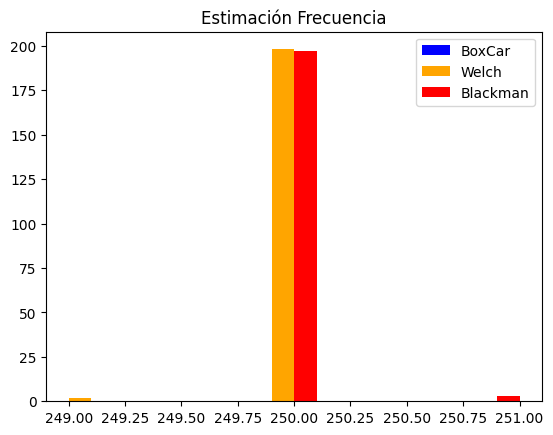

In [7]:
# Voy a imprimir los resultados:
fig4, (ax1) = plt.subplots(1);
plt.title('Estimación Frecuencia')
ax1.hist(est_frec_noisy, color = 'blue', label = 'BoxCar', bins = 10);
ax1.hist(est_frec_welch, color = 'orange', label = 'Welch', bins = 10);
ax1.hist(est_frec_bt, color = 'red', label = 'Blackman', bins = 10);
ax1.legend(loc = 'upper right');

print("\nEstimación de Frecuencia\n")
# Obtengo los estadísticos de cada estimador
boxcar_frec_mean    =  np.mean(est_frec_noisy);
boxcar_frec_var     =  np.var(est_frec_noisy);
print("BoxCar -> La media es de:", boxcar_frec_mean, "y su varianza:", boxcar_frec_var)
welch_frec_mean     =  np.mean(est_frec_welch);
welch_frec_var      =  np.var(est_frec_welch);
print("Welch -> La media es de:", welch_frec_mean, "y su varianza:", welch_frec_var)
blackman_frec_mean  =  np.mean(est_frec_bt);
blackman_frec_var   =  np.var(est_frec_bt);
print("Blackman -> La media es de:", blackman_frec_mean, "y su varianza:", blackman_frec_var)

#### Aumentar SNR
Lo último que queda por hacer es aumentar la relación señal a ruido y observar que ocurre con las simulaciones. Para ello, voy a aumentar la SNR a 10dB (antes era de 3 dB, esto me generaba una mayor dispersión en amplitud, pero en frecuencia no afectaba).
<br> 
Como se comprobó en la tarea pasada, al modificar la SNR, la estimación de frecuencia no debería verse afectada, ya que la misma agrega una incertidumbre en el eje Y, pero no en el X. Si se quisera ver como varía el estimador de frecuencia, la variable que se debe modificar es el jitter con el que se genera la señal senoidal. 
<br>
A pesar de esto, y por la forma en la que estamos calculando el estimador, es probable que si exista dependencia. Esto ocurre debido a que estamos buscando el valor máximo de amplitud para obtener nuestra frecuencia, es decir, **miramos sobre el eje Y y luego bajamos al eje X**. Por ende, al disminuir la variabilidad sobre el eje Y, se obtendrá un efecto similar sobre el X de forma indirecta.

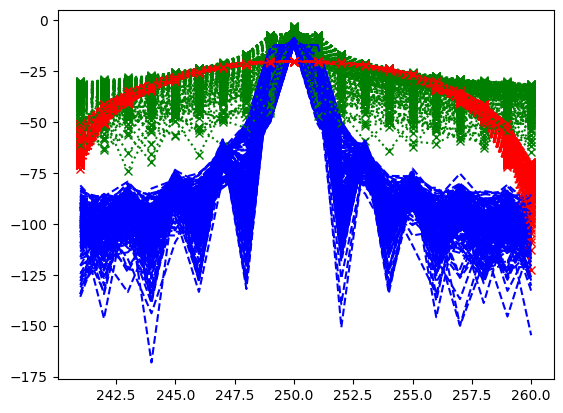

In [12]:
# Con esta frecuencia representaré la señal analógica 
# (voy a trabajar normalizado)

f_cont  = 1000      # Frecuencia continua
N       = f_cont    # Cantidad de muestras de señal continua

# Establezco  la relación señal a ruido que tendrá y la amplitud 
# de la misma (Potencia unitaria)

snr     = 20                 # Relación señal a ruido
A_sin   = math.sqrt(2);     # Amplitud de Senoidal para potencia normalizada

# Por otro lado, la experiencia tendrá "n_run" realizaciones, por lo que me voy
# a crear una matriz vacía que contemple todas las muestras

n_run = 200;
y_sin = np.empty((n_run, N), float);
y_noise = np.empty((n_run, N), float);
noisy_sin = np.empty((n_run, N), float);

# Me creo un eje temporal con el que voy a plotear mis señales
# t_axis = np.arange(0, N*1/f_cont, 1/f_cont);

for i in range(n_run):
    # Primero voy a generar la secuencia de números aleatorios que va representar
    # mi variación en frecuencia
    q = 0.5;
    ohmega_0 = f_cont/4;
    fr = np.random.uniform(-q,q);
    ohmega = ohmega_0 + fr
    
    # Ahora voy a generar mi senoidal con la frecuencia obtenida anteriormente
    t, y_sin[i] = sin_gen(A_sin, 0, ohmega, 0, N, f_cont);
    
    # Luego, voy a calcular el ruido que debo adicionar a la senoidal, con
    # la SNR deseada:
    y_noise[i] = (A_sin/(math.sqrt(2))) * noise_gen(snr, N);
    
    # La señal final será la suma de ambas:
    noisy_sin[i] = y_sin[i] + y_noise[i];

# Este margen lo voy a usar para plotear solamente el area de interes
margin  = 10;
M       = 100;
 
# Armo unos vectores de frecuencia para poder plotear los resultados
frec_axis_cont      = np.arange(0, f_cont, f_cont/N);
frec_axis_cont_filt = (frec_axis_cont > (f_cont/4 - margin)) & (frec_axis_cont <= (f_cont/4 + margin));

fft_noisy_sin       = np.empty((n_run, N), float);

fft_welch_sin       = np.empty((n_run, N), float);
f_welch_sin         = np.empty((n_run, N), int);

frec_axis_blackman  = np.arange(0, N, 1);
fft_bt_sin          = np.empty((n_run, N), float)

fig1, (ax1)         = plt.subplots(1);

# Ahora voy a hacer una fft para conocer el espectro de cada una de esas 
# señales que obtuve
for i in range(n_run):
    fft_noisy_sin[i]                    = 20*np.log10(np.abs(np.fft.fft(noisy_sin[i])/N));
    f_welch_sin[i], fft_welch_sin[i]    = 20*np.log10(np.abs(sg.welch(noisy_sin[i], f_cont, 'bartlett', N, return_onesided = False)));
    fft_bt_sin[i]                       = 20*np.log10(np.abs(sp.cshift(sp.CORRELOGRAMPSD(X = noisy_sin[i], Y = noisy_sin[i], lag = M, window = 'bartlett', NFFT = N), N/2)/(N/2)));
    
    ax1.plot(frec_axis_cont[frec_axis_cont_filt], fft_noisy_sin[i][frec_axis_cont_filt], 'x:g')    
    ax1.plot(frec_axis_cont[frec_axis_cont_filt], fft_welch_sin[i][frec_axis_cont_filt], '--b')
    ax1.plot(frec_axis_cont[frec_axis_cont_filt], fft_bt_sin[i][frec_axis_cont_filt], 'x:r')   

Viendo los gráficos se aprecia claramente como los puntos se concentran cada vez mas sobre el eje Y, pero la variabilidad en el eje X no se ve afectada


Estimación de Frecuencia

BoxCar -> La media es de: 250.005 y su varianza: 0.004974999999999999
Welch -> La media es de: 250.005 y su varianza: 0.004974999999999999
Blackman -> La media es de: 249.995 y su varianza: 0.004974999999999999


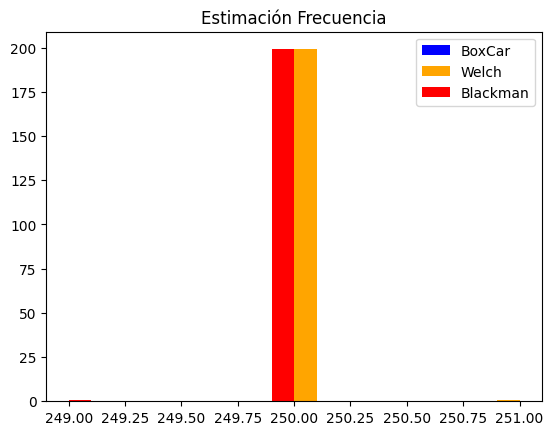

In [13]:
# Ahora voy a obtener el estimador de frecuencia, para ello voy abuscar el valor 
# mas alto de amplitud y me voy a quedar con el argumento de dicho valor
# (el cual representaría el valor de frecuencia)
frec_axis_cont_filt     = frec_axis_cont <= f_cont/2;
frec_axis_blackman_filt = frec_axis_blackman <= f_cont/2;
est_frec_noisy          = np.empty((n_run, 1), float);
est_frec_welch          = np.empty((n_run, 1), float);
est_frec_bt             = np.empty((n_run, 1), float);

for i in range(n_run):
    est_frec_noisy[i]   = np.argmax(fft_noisy_sin[i][frec_axis_cont_filt]);
    est_frec_welch[i]   = np.argmax(fft_welch_sin[i][frec_axis_cont_filt]);
    est_frec_bt[i]      = np.argmax(fft_bt_sin[i][frec_axis_blackman_filt]);

# Voy a imprimir los resultados:
fig4, (ax1) = plt.subplots(1);
plt.title('Estimación Frecuencia')
ax1.hist(est_frec_noisy, color = 'blue', label = 'BoxCar', bins = 10);
ax1.hist(est_frec_welch, color = 'orange', label = 'Welch', bins = 10);
ax1.hist(est_frec_bt, color = 'red', label = 'Blackman', bins = 10);
ax1.legend(loc = 'upper right');

print("\nEstimación de Frecuencia\n")
# Obtengo los estadísticos de cada estimador
boxcar_frec_mean    =  np.mean(est_frec_noisy);
boxcar_frec_var     =  np.var(est_frec_noisy);
print("BoxCar -> La media es de:", boxcar_frec_mean, "y su varianza:", boxcar_frec_var)
welch_frec_mean     =  np.mean(est_frec_welch);
welch_frec_var      =  np.var(est_frec_welch);
print("Welch -> La media es de:", welch_frec_mean, "y su varianza:", welch_frec_var)
blackman_frec_mean  =  np.mean(est_frec_bt);
blackman_frec_var   =  np.var(est_frec_bt);
print("Blackman -> La media es de:", blackman_frec_mean, "y su varianza:", blackman_frec_var)

Los resultados corroboran lo que mencioné anteriormente. Al diminuir la SNR, diminuye la variación de amplitud, y por la forma en la que se calcula el estimador frecuencia, tambien vemos una disminución en la variabilidad del mismo.